In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image

import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 1.14.0


Using TensorFlow backend.


In [32]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for expression in os.listdir("train/"):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img("train/" + expression + "/" +os.listdir("train/" + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

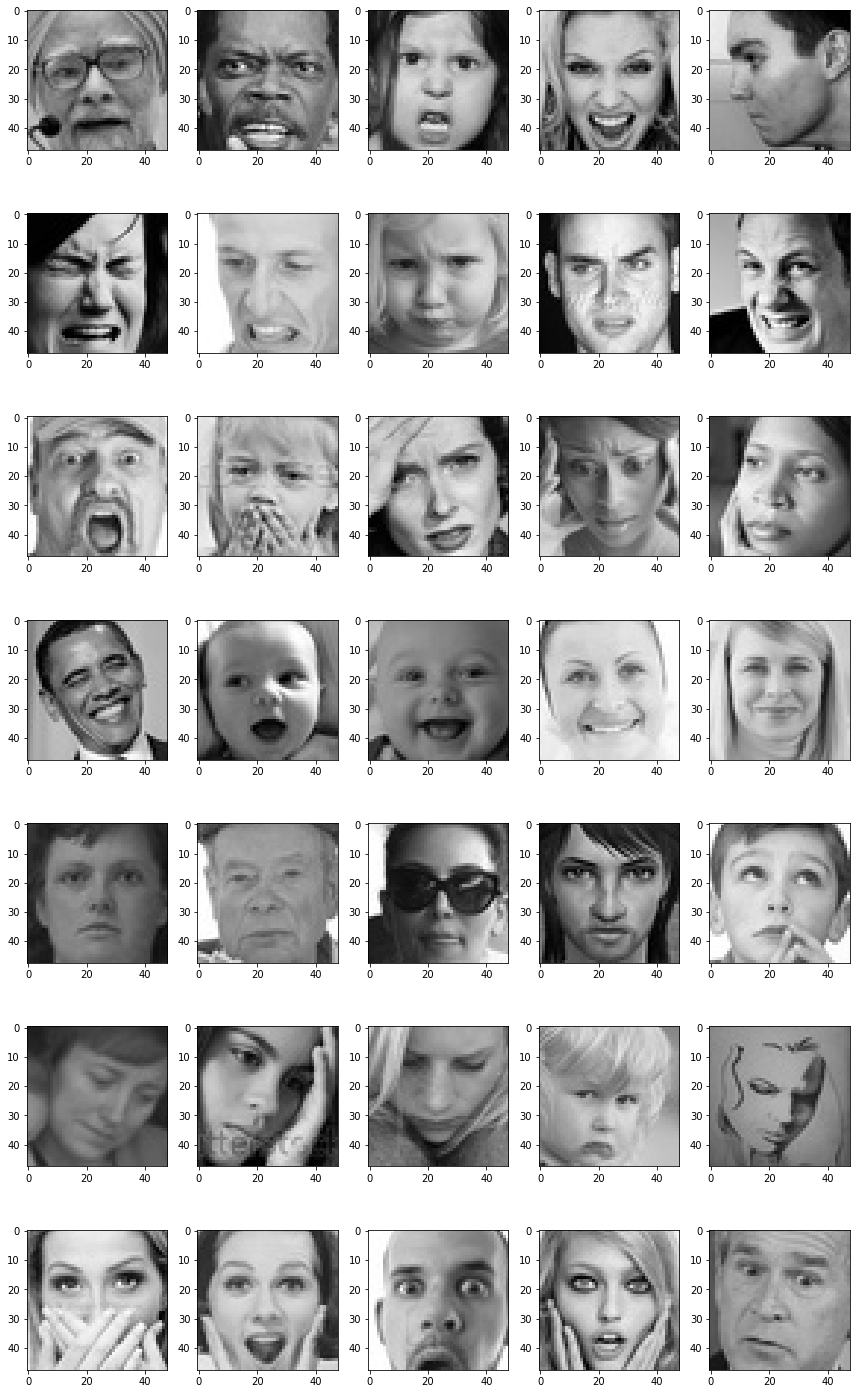

In [33]:
plot_example_images(plt).show()

In [34]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression)))+" "+expression+" images")

3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


In [37]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("train/",target_size=(img_size,img_size),color_mode='grayscale',
                                                   batch_size=batch_size,class_mode='categorical',shuffle=True)
datagen_test = ImageDataGenerator(horizontal_flip=True)
test_generator = datagen_test.flow_from_directory("validation/",target_size=(img_size,img_size),color_mode='grayscale',
                                                   batch_size=batch_size,class_mode='categorical',shuffle=True)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [42]:
model = Sequential()
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7,activation = 'softmax'))

opt = Adam(lr=0.0005)

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
__

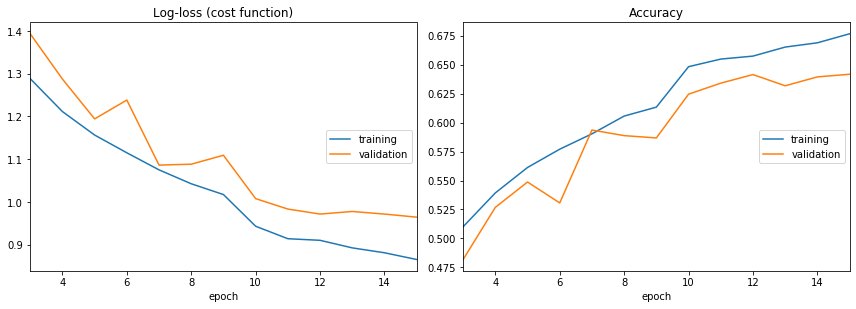

Log-loss (cost function):
training   (min:    0.865, max:    1.720, cur:    0.865)
validation (min:    0.964, max:    1.524, cur:    0.964)

Accuracy:
training   (min:    0.350, max:    0.677, cur:    0.677)
validation (min:    0.416, max:    0.642, cur:    0.642)

Epoch 00015: saving model to model_weights.h5
450/450 [==============================] - 1143s 3s/step - loss: 0.8650 - acc: 0.6767 - val_loss: 0.9641 - val_acc: 0.6418


In [49]:
from livelossplot.tf_keras import PlotLossesCallback
epochs = 15
steps_per_epochs = train_generator.n//train_generator.batch_size
validation_steps = test_generator.n//test_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')
callbacks = [PlotLossesCallback(),checkpoint,reduce_lr]
history = model.fit(x=train_generator,steps_per_epoch=steps_per_epochs,epochs=epochs,validation_data=test_generator,validation_steps=validation_steps,callbacks = callbacks)

In [50]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)